<a href="https://colab.research.google.com/github/sayid-alt/student-performance-factor-analysis/blob/main/%5BKlasifikasi%5D_Submission_Akhir_BMLP_Sayid_Muhammad_Heykal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import urllib.request

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, LearningCurveDisplay
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [53]:
RAW_FILE = 'https://raw.githubusercontent.com/sayid-alt/student-performance-factor-analysis/refs/heads/main/datasets/data-labeled.csv'

def fetch_clustered_data(link=RAW_FILE):
  download_link = urllib.request.urlretrieve(link, 'clustering.csv')
  print(f'\nsuccessfull download {download_link}')
  df = pd.read_csv('clustering.csv', encoding='utf-8', index_col=0)
  return df

In [54]:
df_clustered = fetch_clustered_data()


successfull download ('clustering.csv', <http.client.HTTPMessage object at 0x7fda23a7f640>)


In [55]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6378 entries, 0 to 6606
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   hours_studied                6378 non-null   int64 
 1   attendance                   6378 non-null   int64 
 2   parental_involvement         6378 non-null   object
 3   access_to_resources          6378 non-null   object
 4   extracurricular_activities   6378 non-null   object
 5   sleep_hours                  6378 non-null   int64 
 6   previous_scores              6378 non-null   int64 
 7   motivation_level             6378 non-null   object
 8   internet_access              6378 non-null   object
 9   tutoring_sessions            6378 non-null   int64 
 10  family_income                6378 non-null   object
 11  teacher_quality              6378 non-null   object
 12  school_type                  6378 non-null   object
 13  peer_influence               6378 non-

In [56]:
df_clustered.head()

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,...,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score,exam_score_indicator,hours_studied_indicator,tutoring_sessions_indicator,cluster
0,23,84,Low,High,No,7,73,Low,Yes,0,...,3,No,High School,Near,Male,67,C,Medium,Low,0
1,19,64,Low,Medium,No,8,59,Low,Yes,2,...,4,No,College,Moderate,Female,61,C,Medium,Low,6
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,...,4,No,Postgraduate,Near,Male,74,B,Medium,Low,1
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,...,4,No,High School,Moderate,Male,71,B,Medium,Low,2
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,...,4,No,College,Near,Female,70,B,Medium,Medium,6


Text(0.5, 1.0, 'Frequency of Clusters')

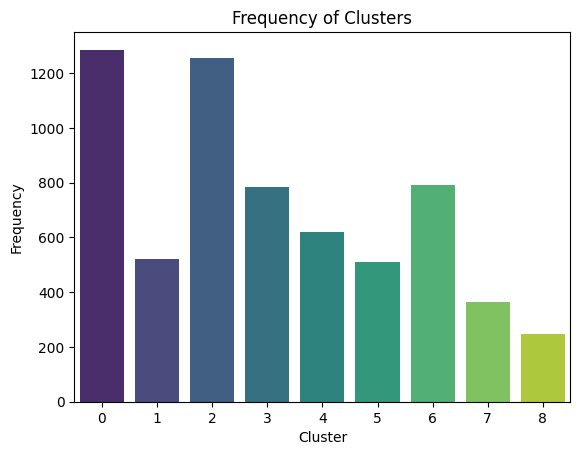

In [62]:
sns.countplot(x='cluster', data=df_clustered, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Frequency of Clusters')

## **2.1 Encoding**

In [58]:
categorical_cols = df_clustered.select_dtypes(include='object').columns

ordinal_features = ['parental_involvement',
                    'access_to_resources',
                    'motivation_level',
                    'family_income',
                    'teacher_quality',
                    'parental_education_level',
                    'distance_from_home',
                    'hours_studied_indicator',
                    'exam_score_indicator',
                    'tutoring_sessions_indicator']

nominal_features = df_clustered[categorical_cols].columns.difference(ordinal_features).tolist()

print(f'ordinal_features: {ordinal_features}\n')
print(f'nominal_features: {nominal_features}')

ordinal_features: ['parental_involvement', 'access_to_resources', 'motivation_level', 'family_income', 'teacher_quality', 'parental_education_level', 'distance_from_home', 'hours_studied_indicator', 'exam_score_indicator', 'tutoring_sessions_indicator']

nominal_features: ['extracurricular_activities', 'gender', 'internet_access', 'learning_disabilities', 'peer_influence', 'school_type']


In [59]:
# store each ordinal column classes
class_one_ordinal = [col for col in ordinal_features if 'Medium' in df_clustered[col].unique()]
class_two_ordinal = [col for col in ordinal_features if 'College' in df_clustered[col].unique()]
class_three_ordinal = [col for col in ordinal_features if 'Moderate' in df_clustered[col].unique()]
class_four_ordinal = [col for col in ordinal_features if 'B' in df_clustered[col].unique()]

ordinal_classes = [class_one_ordinal, class_two_ordinal, class_three_ordinal, class_four_ordinal]

# set categories in each ordinal class
categories = [
    ['Low', 'Medium', 'High'],
    ['High School', 'College', 'Postgraduate'],
    ['Near', 'Moderate', 'Far'],
    ['D', 'C', 'B', 'A']
]

print(f'Classes in ordinal features:')
for i, class_i in enumerate(ordinal_classes):
    print(f'class {i+1}: {class_i}\n values: {categories[i]}\n')

Classes in ordinal features:
class 1: ['parental_involvement', 'access_to_resources', 'motivation_level', 'family_income', 'teacher_quality', 'hours_studied_indicator', 'tutoring_sessions_indicator']
 values: ['Low', 'Medium', 'High']

class 2: ['parental_education_level']
 values: ['High School', 'College', 'Postgraduate']

class 3: ['distance_from_home']
 values: ['Near', 'Moderate', 'Far']

class 4: ['exam_score_indicator']
 values: ['D', 'C', 'B', 'A']



In [60]:
# Encode the classes
for i, class_i in enumerate(ordinal_classes):
    enc = OrdinalEncoder(categories=[categories[i]]*len(class_i), dtype=np.int64)
    df_clustered[class_i] = enc.fit_transform(df_clustered[class_i])


# encode the nominal features
for col in nominal_features:
    dummies = pd.get_dummies(df_clustered[col], dtype=int, prefix=col)
    df_clustered = pd.concat([df_clustered, dummies], axis=1)
    df_clustered.drop(col, axis=1, inplace=True)

In [61]:
df_clustered.head()

,hours_studied,attendance,parental_involvement,access_to_resources,sleep_hours,previous_scores,motivation_level,tutoring_sessions,family_income,teacher_quality,...,gender_Male,internet_access_No,internet_access_Yes,learning_disabilities_No,learning_disabilities_Yes,peer_influence_Negative,peer_influence_Neutral,peer_influence_Positive,school_type_Private,school_type_Public
0,23,84,0,2,7,73,0,0,0,1,...,1,0,1,1,0,0,0,1,0,1
1,19,64,0,1,8,59,0,2,1,1,...,0,0,1,1,0,1,0,0,0,1
2,24,98,1,1,7,91,1,2,1,1,...,1,0,1,1,0,0,1,0,0,1
3,29,89,0,1,8,98,1,1,1,1,...,1,0,1,1,0,1,0,0,0,1
4,19,92,1,1,6,65,1,3,1,2,...,0,0,1,1,0,0,1,0,0,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [63]:
X = df_clustered.drop(['cluster'], axis=1)
y = df_clustered['cluster']

print(f'shape of features: {X.shape}')
print(f'shape of target: {y.shape}')

shape of features: (6378, 30)
shape of target: (6378,)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)

portion_train = X_train.shape[0] / X.shape[0]
portion_test = X_test.shape[0] / X.shape[0]

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'percentage of train size: {portion_train:.2f}%')
print(f'percentage of test size: {portion_test:.2f}%')


shape of X_train: (5102, 30)
shape of y_train: (5102,)
shape of X_test: (1276, 30)
shape of y_test: (1276,)
percentage of train size: 0.80%
percentage of test size: 0.20%


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [65]:
knn = KNeighborsClassifier()
lr = LogisticRegression(multi_class='ovr')
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svm = SVC()
nb = MultinomialNB()

knn.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
nb.fit(X_train, y_train)

models = [knn, lr, dt, rf, svm, nb]
models

[KNeighborsClassifier(),
 LogisticRegression(multi_class='ovr'),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 SVC(),
 MultinomialNB()]

Tulis narasi atau penjelasan algoritma yang Anda gunakan.

Algoritma yang akan digunakan berjumlah 6 jenis, untuk melihat perbandingan-perbandingan yang lebih baik pada akurasinya. 6 Jenis teresbut antara lain:
1. `KNN`: Merupakan algoritma yang mengukur jarak antara titik prediksi dengan tetangga2 terdekatnya untuk mengidentifikasi kemiripan dan kelompok dari suatu titik, jenis algoritma in mudah untuk diintrepertasikan dan memungkinkan memakan memori lebih jika terlalu banyak data yang dilatih
2. `LogisticRegression`: Merupakan jenis algoritma yang mengklasifikasi hasil prediksi dengan nilai probabilitas antara 0 - 1, nilai *true* jika nilai probabilitas diatas nilai threshold yang ditentukan. Untuk model jenis ini digunakan parameter `multi_class = ovr` atau one vs rest. dengan membandingkan nilai binary antara satu kelas dan kelas yg lainnya yang bukan dari kelas tersebut.
3. `DecisionTreeClassifier`: Jenis Algoritma dengan memecah fitur menjadi 2 pilihan, dengan mengukur nilai impurity di setiap fitur. Sehingga menjadikan seperti bentuk pohon keputusan
4. `RandomForestClassifier`: Jenis gabungan dari algoritma decision tree dengan memilih random dari pada sub-tree.
5. `SVM`: Jenis algoritma yang memisahkan antar kelas dengan garis hyperplane yang memaksimalkan margin antara garis dan support vektor (titik terdekat dengan hyperplane dari setiap kelas)
6. `Naive Bayes`: jenis algoritma yang berdasarkan probabilitas teorema bayes. Dengan mengasumsikan fitur yang indpenden satu sama lain.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

,Model,Accuracy,F1 Score
0,KNeighborsClassifier,0.264107,0.243197
1,LogisticRegression,0.994514,0.994477
2,DecisionTreeClassifier,1.000000,1.000000
3,RandomForestClassifier,1.000000,1.000000
4,SVC,0.213166,0.102431
5,MultinomialNB,0.738245,0.686714


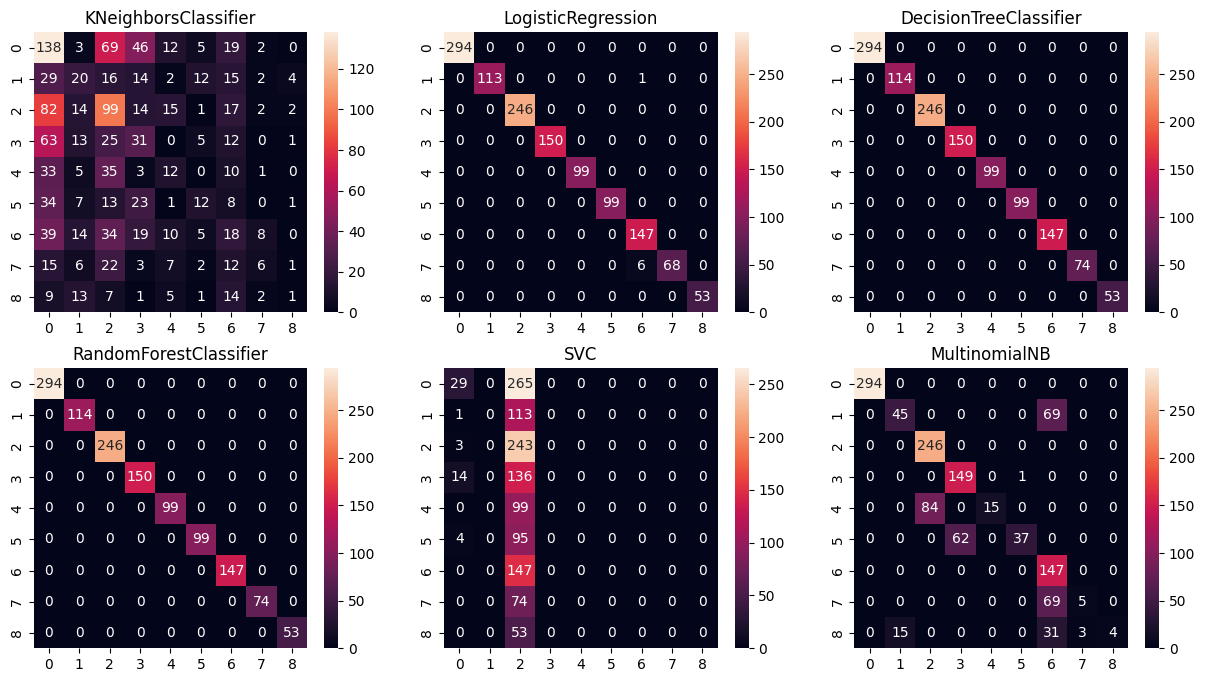

In [66]:
def model_evaluate(model, X_test, y_test):
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  cm = confusion_matrix(y_test, y_pred)

  return accuracy, f1, cm


model_names = []
accuracies = []
f1_scores = []
cms = []

for model in models:
  accuracy, f1, cm = model_evaluate(model, X_test, y_test)
  model_names.append(model.__class__.__name__)
  accuracies.append(accuracy)
  f1_scores.append(f1)
  cms.append(cm)


evals = pd.DataFrame({'Model': model_names,
                      'Accuracy': accuracies,
                      'F1 Score': f1_scores})


ncols = 3
nrows = len(evals) // ncols
fig, axes = plt.subplots(figsize=(15,4*nrows), nrows=nrows, ncols=ncols)
axes = axes.flatten()

for i, ax in enumerate(axes):
  sns.heatmap(cms[i], annot=True, fmt='d', ax=ax)
  ax.set_title(model_names[i], fontsize=12)

evals

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya. <br><br>

**EVALUASI** <br>
Evaluasi dari 6 algoritma diatas menunjukkan keunggulan pada algoritma `Decision Tree`, `RandomForestClassifier`. Dengan mengatur semua parameter pada default value.

**STRATEGY**
Dari hasil diatas pembuatan model saat ini akan menggunakan Decision Tree.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [67]:
#Type your code here

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [68]:
#Type your code here

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

In [97]:
from sklearn.metrics import recall_score, precision_score

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

recall = recall_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')

print(f'train set accuracy: {accuracy_score(y_train, y_train_pred)}')
print(f'test set accuracy: {accuracy_score(y_test, y_test_pred)}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

train set accuracy: 1.0
test set accuracy: 1.0
Recall: 1.0
Precision: 1.0


In [98]:
train_size, train_score, test_score = learning_curve(dt, X_train, y_train, cv=2, verbose=3)

[learning_curve] Training set sizes: [ 255  829 1403 1977 2551]
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=1.000) total time=   0.0s


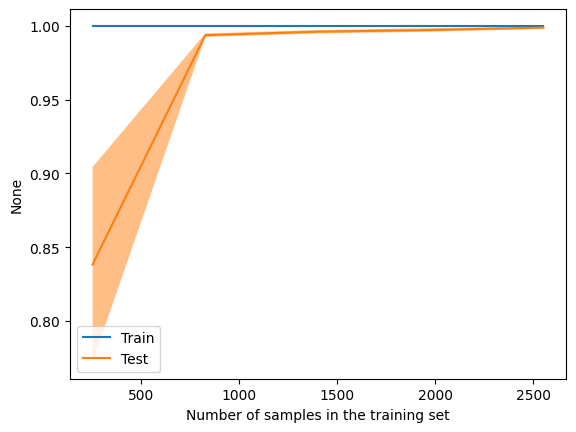

In [95]:
LearningCurveDisplay(train_sizes=train_size, train_scores=train_score, test_scores=test_score).plot()

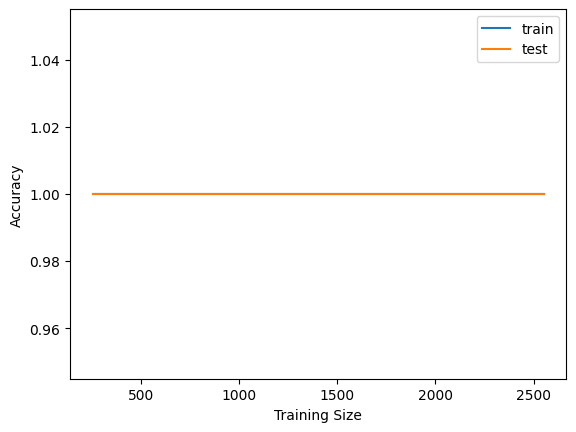

In [99]:
train_score = np.mean(train_score, axis=1)
test_score = np.mean(test_score, axis=1)

plt.plot(train_size, train_score, label='train')
plt.plot(train_size, test_score, label='test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Display grafik yang menunjukkan tidak ada nya overfit atau underfit pada model, mengidentifikasikan model yang memprediksi data secara baik dan dapat di generalisasikan dengan data yang baru